<a href="https://colab.research.google.com/github/GunduSriBhanu/SriBhanu_DATA606/blob/main/src/UCI_Heart_Disease_Prediction_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

Importing necessary libraries for the process of Modeling. 

In [1]:
#importing libraries for data processing
import pandas as pd
import numpy as np
import datetime
import missingno as msno

#importing libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#importing libraries for feature processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

#Performance metrics import
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#Hyperparameters tuning imports
from sklearn.model_selection import GridSearchCV

#Cross validation imports
from sklearn.model_selection import cross_val_score


In [2]:
#ignoring warnings which are irrelavant.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

In [4]:
#Ensemble imports    
from sklearn.ensemble import VotingClassifier

## Loading Dataset of Chicago Crashes  

Reading csv data from heart failures

### Data Cleaning

In [5]:
#Loading the data in the format of csv file using pandas library
df = pd.read_csv('https://raw.githubusercontent.com/GunduSriBhanu/SriBhanu_DATA606/main/data/ml_uci_heart.csv', low_memory=False)

In [6]:
#printing the shape of dataset of 899 rows with 16 ccolumns
print(f'Rows: {df.shape[0]:,} | Columns: {df.shape[1]:,}')

Rows: 899 | Columns: 16


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              899 non-null    int64  
 1   age                     899 non-null    float64
 2   sex                     899 non-null    object 
 3   chest_pain_type         899 non-null    object 
 4   resting blood pressure  899 non-null    float64
 5   cholestoral             899 non-null    float64
 6   fasting_blood_sugar     899 non-null    object 
 7   ekg_results             899 non-null    object 
 8   max_hr                  899 non-null    float64
 9   exercise_angina         899 non-null    object 
 10  ST_depression           899 non-null    float64
 11  slope_of_st             899 non-null    object 
 12  vessels                 899 non-null    float64
 13  thallium                899 non-null    object 
 14  heart_disease           899 non-null    ob

Distribution of target variable

<Axes: >

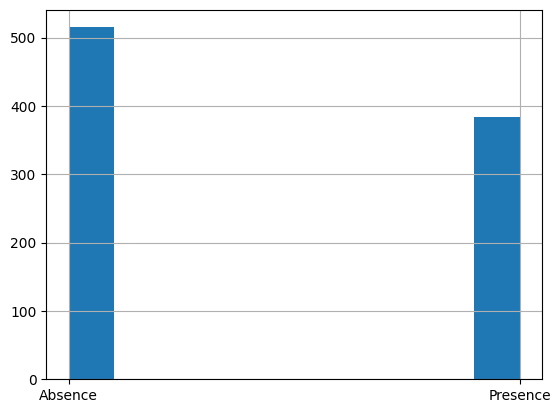

In [8]:
#choosing target variable
target = df['heart_disease']
df.heart_disease.hist()

In [9]:
df.heart_disease.value_counts()

Absence     515
Presence    384
Name: heart_disease, dtype: int64

Class is imbalanced and this dataset seems to have the issues of bias and variance, hence choosing recall or other parameters for modeling than accuracy.

In [10]:
#Dropping unnecessary column
df=df.drop(columns=['Unnamed: 0'])

In [11]:
#numerical and categorical variables for modeling
numeric_cols = df.select_dtypes(include = [np.number])
category_cols = df.drop(columns = 'heart_disease').select_dtypes(include = 'O')
#category_cols = category_cols.drop(columns = ['country','thallium','slope_of_st'])
print("Numeric columns : \n",numeric_cols.columns)
print("\nCategory columns : \n",category_cols.columns)

numerical_vars = numeric_cols.columns.tolist()
categorical_Vars = category_cols.columns.tolist()

Numeric columns : 
 Index(['age', 'resting blood pressure', 'cholestoral', 'max_hr',
       'ST_depression', 'vessels'],
      dtype='object')

Category columns : 
 Index(['sex', 'chest_pain_type', 'fasting_blood_sugar', 'ekg_results',
       'exercise_angina', 'slope_of_st', 'thallium', 'country'],
      dtype='object')


splitting the data with 20% data for test and random state of 124.

In [12]:
#splitting dataset into train and test
cat_features = [x for x in category_cols.columns if x != 'heart_disease']

features = numerical_vars + cat_features
X = df[features]
y = df['heart_disease']

# split the data to training and test datasets with 20% of data for test (test_size = 0.2) and random state of 124 (random_state = 124)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 719
Records in test data: 180

Features:
age
resting blood pressure
cholestoral
max_hr
ST_depression
vessels
sex
chest_pain_type
fasting_blood_sugar
ekg_results
exercise_angina
slope_of_st
thallium
country


Imputing missing data with mean and standardizing the data 

In [13]:
#created a pipeline to process numerical data
num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='mean')),
                           ('standardize_num', StandardScaler())
                        ])

#pipelines on the training data for the numerical features that expected after dropping columns that risking multicolinearity.
X_train_num = num_pipeline.fit_transform(X_train[numerical_vars])

X_train_num.shape

(719, 6)

imputing the categorical data with most frequent values and encoding with binary one hot encoding 

In [14]:
#created a pipeline for the categorical data
from sklearn.preprocessing import LabelEncoder
cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown = 'ignore', sparse = False))])

#pipeline is fitted for the data after applying fit_transform on training data
X_train_cat = cat_pipeline.fit_transform(X_train[cat_features])

X_train_cat
print(X_train_cat.shape)


(719, 22)


Transforming the data into the pipeline and ensuring the shape is retained 

In [15]:
#created a pipeline that combined numerical and categorical data.
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_vars),
                                                      ('create_dummies', cat_pipeline, cat_features)])
#print(processing_pipeline)
print(processing_pipeline.fit_transform(X_train).shape)

data = processing_pipeline.fit_transform(X_train)

(719, 28)


numerical columns after fit transform had 8 columns with categorical 22 columns and finally after transforming with 28 columns ensuring data is retained without any loss

## Logistic Regression

In [16]:
# modeling pipeline to the logistic regression
logreg_pipeline = Pipeline([
        ('data_processing', processing_pipeline),
        ('logreg', LogisticRegression())]
    )


# Fitting the pipeline for logistic regression
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('logreg', LogisticRegression())])

In [17]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Classification report

In [18]:
X_hat = logreg_pipeline.fit(X_train, y_train).predict(X_train)
y_hat = logreg_pipeline.fit(X_train, y_train).predict(X_test)
y_train_hat = logreg_pipeline.fit(X_train, y_train).predict(X_train)

print('----------------------------------------------------------------------------')
print('                              TESTING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_test, y_hat))
print('----------------------------------------------------------------------------')
print('                              TRAINING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_train, y_train_hat))


----------------------------------------------------------------------------
                              TESTING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.96      0.84      0.90       107
    Presence       0.80      0.95      0.87        73

    accuracy                           0.88       180
   macro avg       0.88      0.89      0.88       180
weighted avg       0.89      0.88      0.88       180

----------------------------------------------------------------------------
                              TRAINING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.85      0.91      0.88       408
    Presence       0.87      0.78      0.82       311

    accuracy                           0.85     

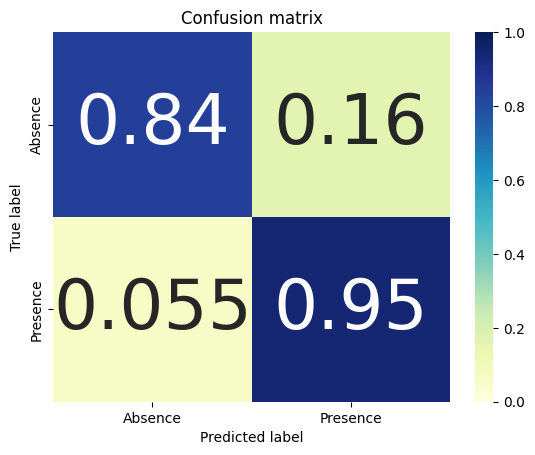

In [19]:
cm = confusion_matrix(y_test, y_hat)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, classes = logreg_pipeline.classes_, title='Confusion matrix')
plt.show()

In [20]:
train_accuracy_lr=accuracy_score(y_train,X_hat)
test_accuracy_lr=accuracy_score(y_test,y_hat)
print(f'Accuracy on train data:{accuracy_score(y_train,X_hat):.2%}')
print(f'Accuracy on test data:{accuracy_score(y_test,y_hat):.2%}')
train_precision_lr = precision_score(y_train,X_hat,average = 'macro')
test_precision_lr = precision_score(y_test,y_hat,average = 'macro')
print(f'Precision on train data:{train_precision_lr:.2%}')
print(f'Precision on test data:{test_precision_lr:.2%}')
train_recall_lr = recall_score(y_train, X_hat, average='macro')
test_recall_lr = recall_score(y_test, y_hat, average='macro')
print(f'Recall on train data:{train_recall_lr:.2%}')
print(f'Recall on test data:{test_recall_lr:.2%}')

Accuracy on train data:85.40%
Accuracy on test data:88.33%
Precision on train data:85.65%
Precision on test data:87.99%
Recall on train data:84.53%
Recall on test data:89.32%


#### Loss Function

In [21]:

pred_proba = logreg_pipeline.predict_proba(X_train)
print("The Log Loss on Training is: ", log_loss(y_train, pred_proba))
pred_proba_t = logreg_pipeline.predict_proba(X_test)
print("The Log Loss on Testing Dataset is: ", log_loss(y_test, pred_proba_t))

The Log Loss on Training is:  0.350884306728851
The Log Loss on Testing Dataset is:  0.3050225686815282


In [22]:

logreg_pipeline.fit(X_train, y_train).score(X_train, y_train)

0.8539638386648123

In [23]:
logreg_pipeline.fit(X_train, y_train).score(X_test, y_test)

0.8833333333333333

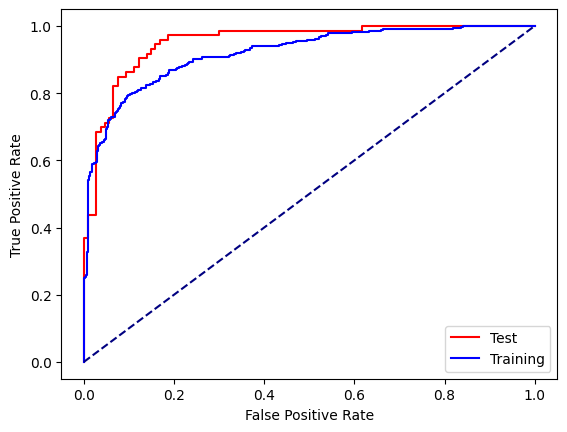

In [24]:
def generate_probs(X, model=logreg_pipeline):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label='Presence')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(X_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(X_train))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [25]:
roc_auc_score(y_train, generate_probs(X_train))

0.9189206229115441

In [26]:
roc_auc_score(y_test, generate_probs(X_test))

0.9525028805530662

#### Comments:
From the data, Random Forest is performed well 

with Accuracy on train data:85.40%

Accuracy on test data:88.33%

Precision on train data:85.65%

Precision on test data:87.99%

Recall on train data:84.53%

Recall on test data:89.32%

with little problems of overfillting, however from the performance metrics the models seems to be performing well with Recall as my parameter of test Recall of 89.32%.

## Random Forest Classifier

In [27]:

rf_pipeline = Pipeline([
    ('data_processing', processing_pipeline),    
    ('dt', RandomForestClassifier(criterion = 'entropy',max_depth=9,min_samples_leaf=2))]
)

rf_pipeline.fit(X_train, y_train)
y_testp_rf = rf_pipeline.fit(X_train, y_train).predict(X_test)
y_trainp_rf = rf_pipeline.fit(X_train, y_train).predict(X_train)

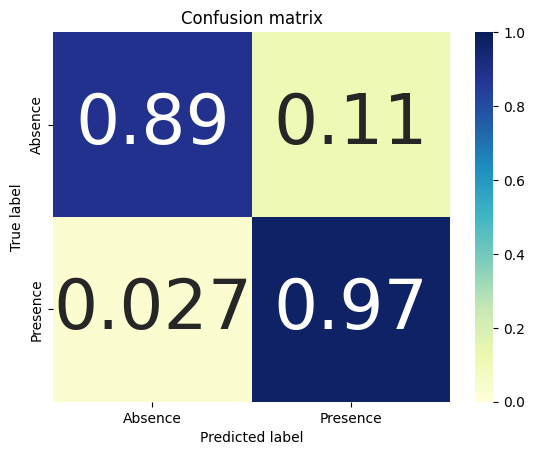

In [28]:
cm = confusion_matrix(y_test, y_testp_rf)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, classes = rf_pipeline.classes_, title='Confusion matrix')
plt.show()

In [29]:

print('----------------------------------------------------------------------------')
print('                              TRAINING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_train, y_trainp_rf))
print('----------------------------------------------------------------------------')
print('                              TESTING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_test, y_testp_rf))

----------------------------------------------------------------------------
                              TRAINING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.95      0.99      0.97       408
    Presence       0.98      0.94      0.96       311

    accuracy                           0.97       719
   macro avg       0.97      0.96      0.96       719
weighted avg       0.97      0.97      0.97       719

----------------------------------------------------------------------------
                              TESTING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.98      0.89      0.93       107
    Presence       0.86      0.97      0.91        73

    accuracy                           0.92     

In [30]:
train_accuracy_rf=accuracy_score(y_train,y_trainp_rf)
test_accuracy_rf=accuracy_score(y_test,y_testp_rf)
print(f'Accuracy on train data:{accuracy_score(y_train,y_trainp_rf):.2%}')
print(f'Accuracy on test data:{accuracy_score(y_test,y_testp_rf):.2%}')
train_precision_rf = precision_score(y_train,y_trainp_rf,average = 'macro')
test_precision_rf = precision_score(y_test,y_testp_rf,average = 'macro')
print(f'Precision on train data:{train_precision_rf:.2%}')
print(f'Precision on test data:{test_precision_rf:.2%}')
train_recall_rf = recall_score(y_train, y_trainp_rf, average='macro')
test_recall_rf = recall_score(y_test, y_testp_rf, average='macro')
print(f'Recall on train data:{train_recall_rf:.2%}')
print(f'Recall on test data:{test_recall_rf:.2%}')

Accuracy on train data:96.52%
Accuracy on test data:92.22%
Precision on train data:96.74%
Precision on test data:91.74%
Recall on train data:96.21%
Recall on test data:93.02%


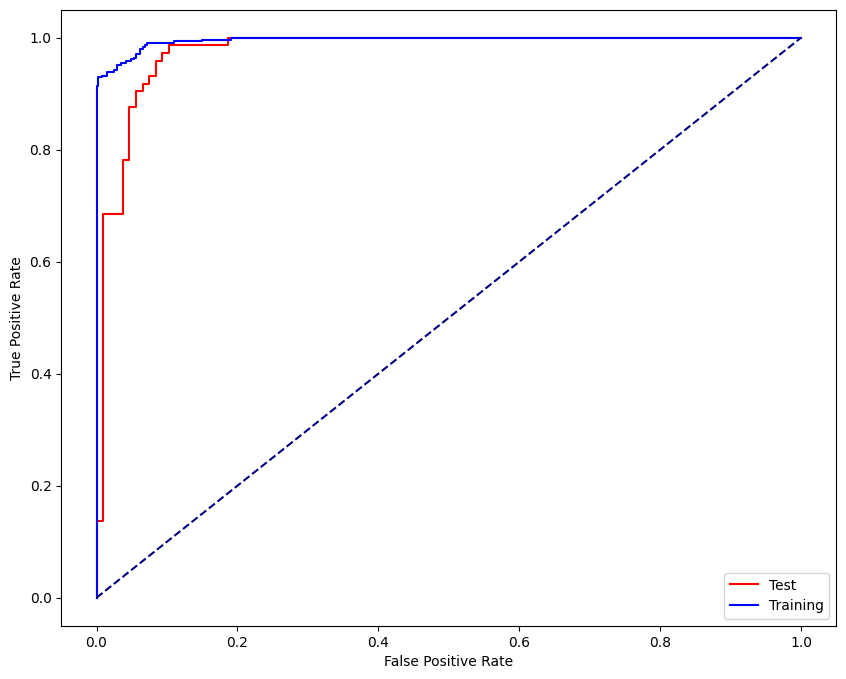

In [31]:
def generate_probs(X, model=rf_pipeline):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label='Presence')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(X_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(X_train))
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [32]:
roc_auc_score(y_train, generate_probs(X_train))

0.9958388500094573

In [33]:
roc_auc_score(y_test, generate_probs(X_test))

0.9758033542440148

#### Comments:
From the data, Random Forest is performed well 

with Accuracy on train data:96.11%

Accuracy on test data:91.67%

Precision on train data:96.45%

Precision on test data:91.22%

Recall on train data:95.69%

Recall on test data:92.56%

with little problems of overfillting, however from the performance metrics the models seems to be performing well with Recall as my parameter of test Recall of 92.56%.

### Decision Tree

In [34]:

dttree_pipeline = Pipeline([
    ('data_processing', processing_pipeline),    
    ('dt', DecisionTreeClassifier(criterion = 'entropy',max_depth=9,min_samples_leaf=2))]
)
dttree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        min_samples_leaf=2))])

In [35]:
y_testp_dt = dttree_pipeline.fit(X_train, y_train).predict(X_test)
y_trainp_dt = dttree_pipeline.fit(X_train, y_train).predict(X_train)

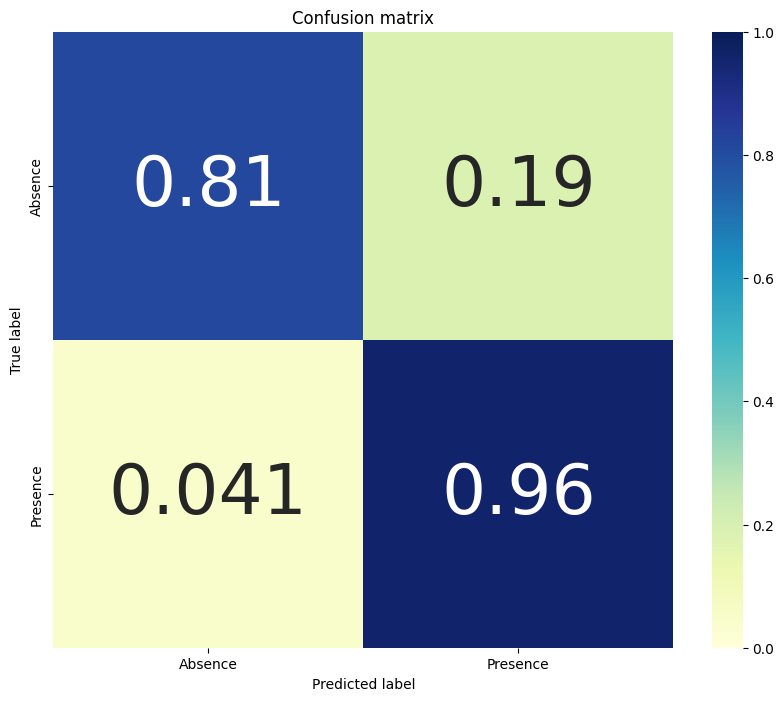

In [36]:
cm = confusion_matrix(y_test, y_testp_dt)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, classes = dttree_pipeline.classes_, title='Confusion matrix')
plt.show()

In [37]:


print('----------------------------------------------------------------------------')
print('                              TRAINING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_train, y_trainp_dt))
print('----------------------------------------------------------------------------')
print('                              TESTING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_test, y_testp_dt))


----------------------------------------------------------------------------
                              TRAINING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.96      0.98      0.97       408
    Presence       0.97      0.95      0.96       311

    accuracy                           0.97       719
   macro avg       0.97      0.96      0.96       719
weighted avg       0.97      0.97      0.97       719

----------------------------------------------------------------------------
                              TESTING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.97      0.81      0.88       107
    Presence       0.78      0.96      0.86        73

    accuracy                           0.87     

In [38]:
train_accuracy_dt=accuracy_score(y_train,y_trainp_dt)
test_accuracy_dt=accuracy_score(y_test,y_testp_dt)
print(f'Accuracy on train data:{accuracy_score(y_train,y_trainp_dt):.2%}')
print(f'Accuracy on test data:{accuracy_score(y_test,y_testp_dt):.2%}')
train_precision_dt = precision_score(y_train,y_trainp_dt,average = 'macro')
test_precision_dt = precision_score(y_test,y_testp_dt,average = 'macro')
print(f'Precision on train data:{train_precision_dt:.2%}')
print(f'Precision on test data:{test_precision_dt:.2%}')
train_recall_dt = recall_score(y_train, y_trainp_dt, average='macro')
test_recall_dt = recall_score(y_test, y_testp_dt, average='macro')
print(f'Recall on train data:{train_recall_dt:.2%}')
print(f'Recall on test data:{test_recall_dt:.2%}')

Accuracy on train data:96.52%
Accuracy on test data:87.22%
Precision on train data:96.64%
Precision on test data:87.22%
Recall on train data:96.29%
Recall on test data:88.60%


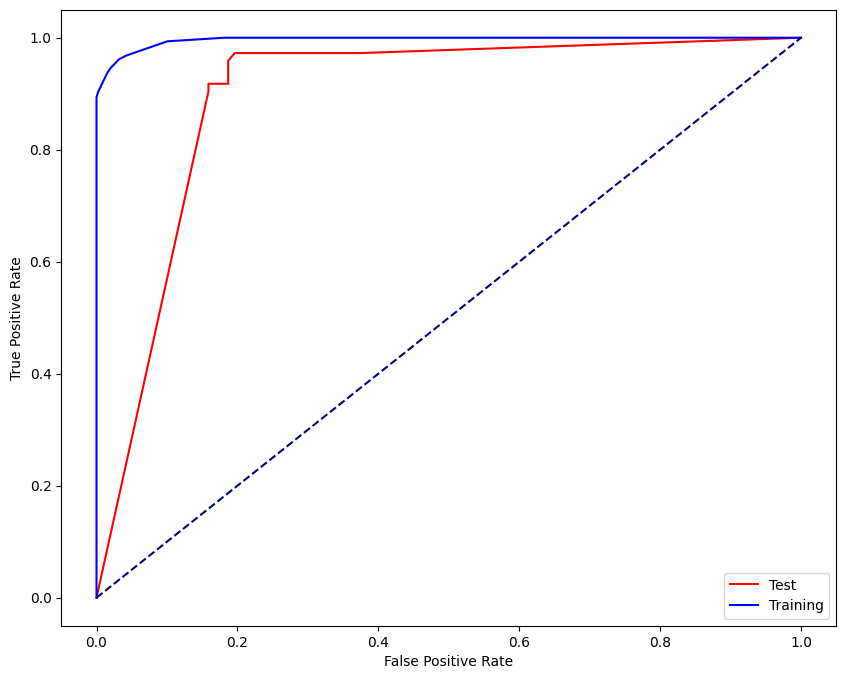

In [39]:
def generate_probs(X, model=dttree_pipeline):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label='Presence')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(X_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(X_train))
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [40]:
roc_auc_score(y_train, generate_probs(X_train))

0.9961619696109956

In [41]:
roc_auc_score(y_test, generate_probs(X_test))

0.8968762002304442

#### Comments:
From the data, Decision tree Classifier is performed well 

withAccuracy on train data:96.52%

Accuracy on test data:87.22%

Precision on train data:96.64%

Precision on test data:87.22%

Recall on train data:96.29%

Recall on test data:88.60%

with little problems of overfillting, however from the performance metrics the models seems to be performing well with Recall as my parameter of test Recall of 88.60%.

### MLP Classifier

In [42]:
mlp_pipeline = Pipeline([
    ('data_processing', processing_pipeline),    
    ('mlp', MLPClassifier(hidden_layer_sizes=(25,), max_iter=100))]
)
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('mlp', MLPClassifier(hidden_layer_sizes=(25,), max_iter=100))])

In [43]:
y_testp_mlp = mlp_pipeline.fit(X_train, y_train).predict(X_test)
y_trainp_mlp = mlp_pipeline.fit(X_train, y_train).predict(X_train)

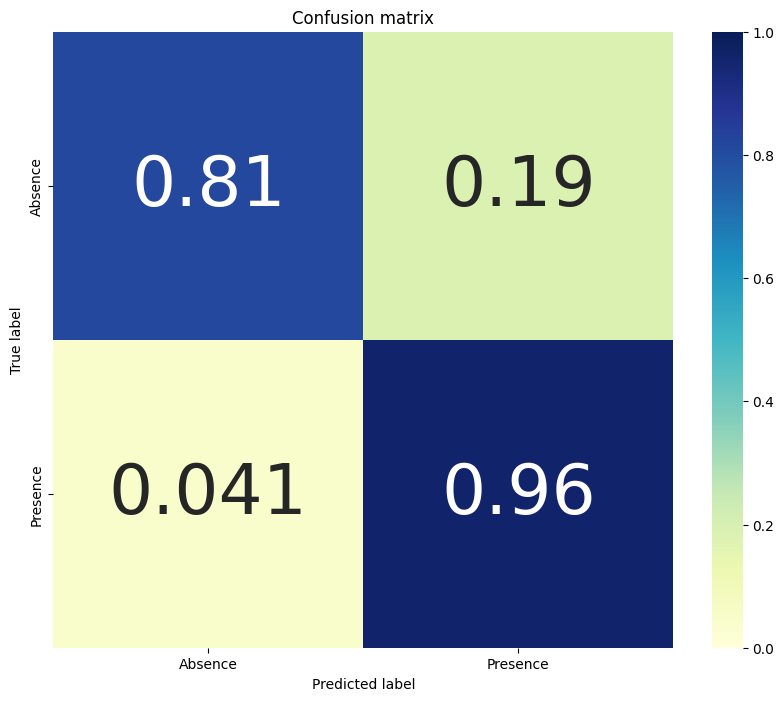

In [44]:
cm = confusion_matrix(y_test, y_testp_dt)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, classes = mlp_pipeline.classes_, title='Confusion matrix')
plt.show()

In [45]:

print('----------------------------------------------------------------------------')
print('                              TRAINING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_train, y_trainp_mlp))
print('----------------------------------------------------------------------------')
print('                              TESTING DATA                                 ')
print('----------------------------------------------------------------------------')
print(classification_report(y_test, y_testp_mlp))

----------------------------------------------------------------------------
                              TRAINING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.87      0.92      0.89       408
    Presence       0.88      0.81      0.85       311

    accuracy                           0.87       719
   macro avg       0.88      0.87      0.87       719
weighted avg       0.87      0.87      0.87       719

----------------------------------------------------------------------------
                              TESTING DATA                                 
----------------------------------------------------------------------------
              precision    recall  f1-score   support

     Absence       0.97      0.84      0.90       107
    Presence       0.80      0.96      0.88        73

    accuracy                           0.89     

In [46]:
train_accuracy_mlp=accuracy_score(y_train,y_trainp_mlp)
test_accuracy_mlp=accuracy_score(y_test,y_testp_mlp)
print(f'Accuracy on train data:{accuracy_score(y_train,y_trainp_mlp):.2%}')
print(f'Accuracy on test data:{accuracy_score(y_test,y_testp_mlp):.2%}')
train_precision_mlp = precision_score(y_train,y_trainp_mlp,average = 'macro')
test_precision_mlp = precision_score(y_test,y_testp_mlp,average = 'macro')
print(f'Precision on train data:{train_precision_mlp:.2%}')
print(f'Precision on test data:{test_precision_mlp:.2%}')
train_recall_mlp = recall_score(y_train, y_trainp_mlp, average='macro')
test_recall_mlp = recall_score(y_test, y_testp_mlp, average='macro')
print(f'Recall on train data:{train_recall_mlp:.2%}')
print(f'Recall on test data:{test_recall_mlp:.2%}')

Accuracy on train data:87.34%
Accuracy on test data:88.89%
Precision on train data:87.53%
Precision on test data:88.62%
Recall on train data:86.63%
Recall on test data:90.00%


In [47]:
roc_auc_score(y_train, generate_probs(X_train))

0.9961619696109956

In [48]:
roc_auc_score(y_test, generate_probs(X_test))

0.8968762002304442

#### Comments:
From the data, MLP Classifier is performed well 

with Accuracy on train data:88.73%

Accuracy on test data:88.33%

Precision on train data:88.75%

Precision on test data:87.99%

Recall on train data:88.24%

Recall on test data:89.32%

with little problems of overfillting, however from the performance metrics the models seems to be performing well with Recall as my parameter of test Recall of 89.32%.

### Comparison of plots

### Test Accuracy

In [49]:
import plotly.express as px

# create a sample dataframe with accuracy values
data = {'Model': ['Logreg', 'RandomForest', 'DecisionTree', 'MLP'],
        'Accuracy': [test_accuracy_lr, test_accuracy_rf,test_accuracy_dt,test_accuracy_mlp]}
df = pd.DataFrame(data)

# convert the accuracy values to percentages
df['Accuracy'] = df['Accuracy']*100

# create the box plot using Plotly Express
fig = px.bar(df.sort_values(by="Accuracy", ascending=False), x='Model', y='Accuracy',
             labels={'Accuracy': 'Accuracy (%)'},
             title='Model Accuracy',
             template="plotly_dark")
fig.show()


In [50]:

# create a sample dataframe with accuracy values
data = {'Model': ['Logreg', 'RandomForest', 'DecisionTree', 'MLP'],
        'Recall': [test_recall_lr, test_recall_rf,test_recall_dt,test_recall_mlp]}
df = pd.DataFrame(data)

# convert the accuracy values to percentages
df['Recall'] = df['Recall']*100

# create the box plot using Plotly Express
fig = px.bar(df.sort_values(by="Recall", ascending=False), x='Model', y='Recall',
             labels={'Recall': 'Recall (%)'},
             title='Model Recall',
             template="plotly_dark")
fig.show()


#### Comments:
From the data of comparison of models, from both Accuracy and Recall performance metrics are considered, the Random Forest data is performing well with little overfitting problems. Hence needs hyperparameter tuning.

## Hyper parameter tuning

#### Logistic Regression 

In [51]:
p = Pipeline([('data_processing', processing_pipeline), 
              ('model', LogisticRegression(solver = 'liblinear', penalty = 'l2'))
             ])

params = {'model__C': [0.01,1,2,5,8,9,10,11,12,13]}

first_search = GridSearchCV(p, param_grid=params)
first_search = first_search.fit(X_train, y_train)

print(f'Validation score: {first_search.best_score_:.2%}')
print(f'Train score: {first_search.score(X_train, y_train):.2%}')
print(f'Test score: {first_search.score(X_test, y_test):.2%}')
first_search.best_estimator_

Validation score: 82.34%
Train score: 83.31%
Test score: 88.33%


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('model', LogisticRegression(C=0.01, solver='liblinear'))])

In [52]:
params = {'model__C': [0.001,0.001,0.01,0.1,1]}

second = GridSearchCV(p, param_grid=params)
second = second.fit(X_train, y_train)

print(f'Validation score: {second.best_score_:.2%}')
print(f'Train score: {second.score(X_train, y_train):.2%}')
print(f'Test score: {second.score(X_test, y_test):.2%}')
second.best_estimator_

Validation score: 83.03%
Train score: 84.42%
Test score: 88.33%


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('model', LogisticRegression(C=0.1, solver='liblinear'))])

### Decision Tree

In [53]:
tr = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier(criterion = 'entropy'))]
)

param_grid = [
  {
   'dt__max_depth': [1,2,5,9,12],
   'dt__min_samples_leaf': [1.5,2,2.5],
   'dt__min_samples_split':[2,3,6,9]
   
  }
 ]

tree_first = GridSearchCV(estimator=tr, 
                           param_grid=param_grid)
tree_first = tree_first.fit(X_train, y_train)
print(f'Validation score: {tree_first.best_score_:.2%}')
print(f'Train score: {tree_first.score(X_train, y_train):.2%}')
print(f'Test score: {tree_first.score(X_test, y_test):.2%}')
tree_first.best_estimator_

Validation score: 83.87%
Train score: 96.38%
Test score: 86.67%


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        min_samples_leaf=2,
                                        min_samples_split=3))])

In [54]:
tr = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier(criterion = 'entropy',max_depth=9,min_samples_leaf=2))]
)
param_grid = [
  {
   'dt__min_samples_split':[2.5,3,3.5,4,5.5,6,6.5,7,8,9,10]
  }
 ]

tree_second = GridSearchCV(estimator=tr, 
                           param_grid=param_grid)
tree_second = tree_second.fit(X_train, y_train)
print(f'Validation score: {tree_second.best_score_:.2%}')
print(f'Train score: {tree_second.score(X_train, y_train):.2%}')
print(f'Test score: {tree_second.score(X_test, y_test):.2%}')
tree_second.best_estimator_

Validation score: 83.59%
Train score: 96.52%
Test score: 87.22%


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        min_samples_leaf=2,
                                        min_samples_split=4))])

### Random Forest

In [55]:
rf = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier(criterion = 'entropy',n_estimators=20))]
)

param_grid = [{
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}]

rf_first = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, cv=5)
rf_first = rf_first.fit(X_train, y_train)
print(f'Validation score: {rf_first.best_score_:.2%}')
print(f'Train score: {rf_first.score(X_train, y_train):.2%}')
print(f'Test score: {rf_first.score(X_test, y_test):.2%}')
rf_first.best_estimator_

Validation score: 87.48%
Train score: 97.91%
Test score: 92.78%


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=20))])

In [56]:
rf = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier(criterion = 'entropy',n_estimators=20))]
)

param_grid = [{
    #'rf__n_estimators': [45,50,51,52,53,55,60],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}]

rf_second = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, cv=5)
rf_second = rf_second.fit(X_train, y_train)
print(f'Validation score: {rf_second.best_score_:.2%}')
print(f'Train score: {rf_second.score(X_train, y_train):.2%}')
print(f'Test score: {rf_second.score(X_test, y_test):.2%}')
rf_second.best_estimator_

Validation score: 87.06%
Train score: 97.77%
Test score: 91.67%


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting blood pressure',
                                                   'cholestoral', 'max_hr',
                                                   'ST_depression',
                                                   'vessels']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['sex', 'chest_pain_type',
                                                   'fasting_blood_sugar',
                                                   'ekg_results',
                                                   'exercise_angina',
                                                   'slope_of_st', 'thallium',
                                                   'country'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=20))])

#### Comments:
From all the models, Random Forest models is performing better after hyperparameter tuning, but not much improvement in the scores.

### Cross validation with parameters after hyper parameter tuning

In [57]:
def create_holdout_splits(X, y):
    x_train, x_val, y_trainv, y_val = train_test_split(X_train, y_train, test_size=0.2)
    return x_train, x_val, y_trainv, y_val

x_train, x_val, y_trainv, y_val = create_holdout_splits(X, y)

print(f'Training sample: {x_train.shape[0]:,}')
print(f'Validation sample: {x_val.shape[0]:,}')
print(f'Test sample: {X_test.shape[0]:,}')

Training sample: 575
Validation sample: 144
Test sample: 180


#### Logistic Regression 

In [58]:
plr = Pipeline([('data_processing', processing_pipeline), 
              ('model', LogisticRegression(solver = 'liblinear', penalty = 'l2', C=0.1))
             ])
plr = plr.fit(X_train, y_train)
m_lgreg_models = {}
for i in range(1,6):
    m_lgreg_models[i] = plr.fit(x_train, y_trainv)
    #print(m_lgreg_models[i])
    
print('Models fitted')

Models fitted


In [59]:
y_val_lgreg = {}
for k in range(1,6):
    y_val_lgreg[k] = m_lgreg_models[k].predict(x_val)
    
   

#### Decision tree

In [60]:
ptr = Pipeline([('data_processing', processing_pipeline), 
              ('dt', DecisionTreeClassifier(criterion = 'entropy', max_depth = 9,min_samples_leaf=2, min_samples_split=7))
             ])
ptr = ptr.fit(X_train, y_train)
m_tr_models = {}
for i in range(1,6):
    m_tr_models[i] = ptr.fit(x_train, y_trainv)
    
print('Models fitted')

Models fitted


In [61]:
y_val_tr = {}
for k in range(1,6):
    y_val_tr[k] = m_tr_models[k].predict(x_val)
    


### Random Forest

In [62]:
rfc = Pipeline([('data_processing', processing_pipeline), 
              ('model', RandomForestClassifier(criterion = 'entropy',n_estimators=20))
             ])
rfc = rfc.fit(X_train, y_train)
m_rf_models = {}
for i in range(1,6):
    m_rf_models[i] = rfc.fit(x_train, y_trainv)
        
print('Models fitted')

Models fitted


In [63]:
y_val_rfc = {}
for k in range(1,6):
    y_val_rfc[k] = m_rf_models[k].predict(x_val)

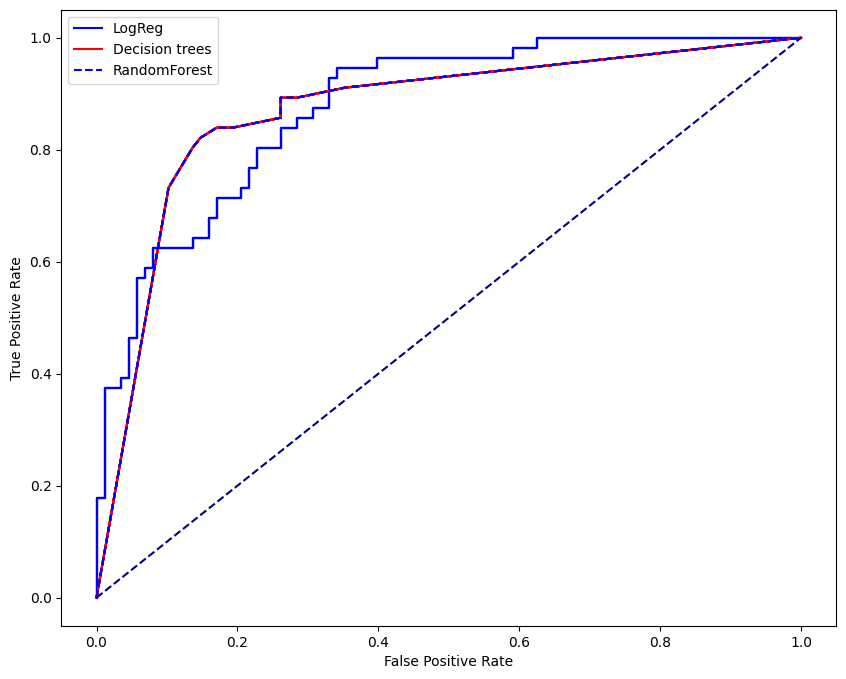

In [64]:
fpr_val_lgreg = {}
tpr_val_lgreg = {}
fpr_val_tr = {}
tpr_val_tr = {}
fpr_val_rf = {}
tpr_val_rf = {}
for k in range(1,6):
    fpr_val_lgreg[k], tpr_val_lgreg[k] = generate_roc(y_val,
                                          generate_probs(x_val, model=m_lgreg_models[k]))
    fpr_val_tr[k], tpr_val_tr[k] = generate_roc(y_val,
                                          generate_probs(x_val, model=m_tr_models[k]))
    fpr_val_rf[k], tpr_val_rf[k] = generate_roc(y_val,
                                          generate_probs(x_val, model=m_rf_models[k]))
    
    

for i in range(1,6):
    plt.plot(fpr_val_lgreg[i], tpr_val_lgreg[i],'-b')
    plt.plot(fpr_val_tr[i], tpr_val_tr[i],'-r')    
    plt.plot(fpr_val_tr[i], tpr_val_tr[i],'--b')
    


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['LogReg','Decision trees','RandomForest'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [65]:
print("validation roc score of logreg: ",roc_auc_score(y_val, generate_probs(x_val, model=plr)))
print("validation roc score of dec tree: ",roc_auc_score(y_val, generate_probs(x_val, model=ptr)))
print("validation roc score of RandomForest: ",roc_auc_score(y_val, generate_probs(x_val, model=rfc)))

validation roc score of logreg:  0.877637987012987
validation roc score of dec tree:  0.8692167207792207
validation roc score of RandomForest:  0.9310064935064936


Text(0, 0.5, '% of ROC_AUC Score')

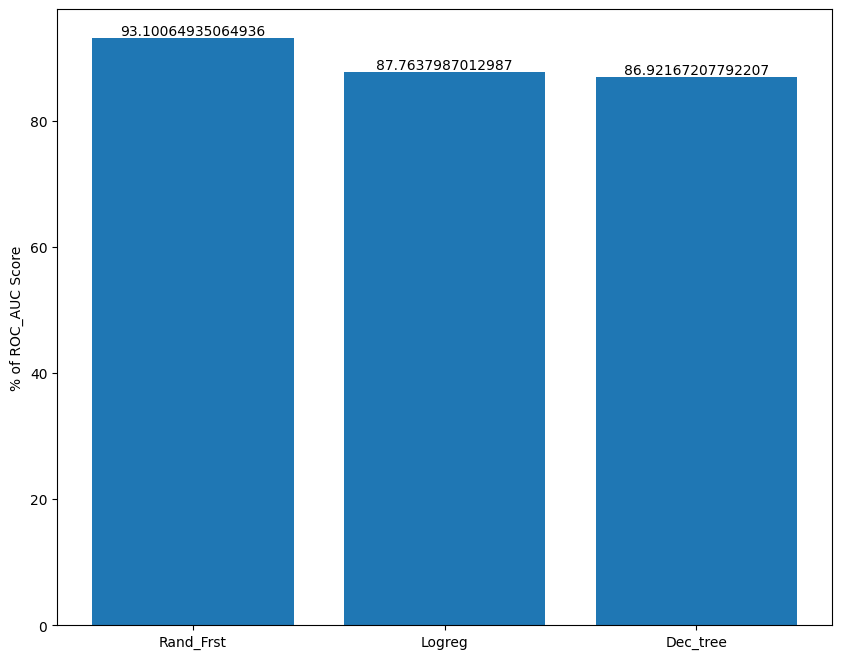

In [66]:
import matplotlib.pyplot as plt

# create a sample dataframe with roc_auc values
data = {'Model': ['Logreg','Dec_tree','Rand_Frst'],
        'ROC_AUC': [roc_auc_score(y_val, generate_probs(x_val, model=plr)),roc_auc_score(y_val, generate_probs(x_val, model=ptr)),roc_auc_score(y_val, generate_probs(x_val, model=rfc))]}
df = pd.DataFrame(data)

# convert the roc_auc values to percentages
df['ROC_AUC'] = df['ROC_AUC']*100

df_sorted = df.sort_values(by='ROC_AUC', ascending=False)

plt.bar(df_sorted['Model'], df_sorted['ROC_AUC'])
# set the x-axis labels
plt.xticks(df['Model'])

# add text labels to the bars
for i, v in enumerate(df_sorted['ROC_AUC']):
    plt.text(i, v, str(v), ha='center', va='bottom')   

plt.ylabel('% of ROC_AUC Score')


### Comments on results comparison:
Overall, random forest performed with highest score while least is decision tree

### Ensemble

#### Voting Classifier for evaluating the models in Ensemble with ROC

In [67]:
score_lst = []
clf1 = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=0)
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2, random_state=1)
clf3 = RandomForestClassifier(n_estimators=20)

pipe1 = Pipeline([('data_processing', processing_pipeline),('logreg', clf1)])
pipe2 = Pipeline([('data_processing', processing_pipeline),('tree', clf2)])
pipe3 = Pipeline([('data_processing', processing_pipeline),('rfc', clf3)])

labs = ['Logistic Regression', 'Decision Tree', 'Random Forest']
clfs = [pipe1, pipe2, pipe3]
clfs = zip(labs, clfs)

for lab, clf in clfs:
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC {scores.mean():.2f} (+/- {scores.std():.2f}) [{lab}]')
    #print(scores.mean())
    score_lst.append(scores.mean())

ems = [('lr', pipe1),('dt', pipe2),('rfc', pipe3)]
clf4 = VotingClassifier(estimators= ems, weights=None, voting='soft')
clf4 = clf4.fit(X_train,y_train)

scores = cross_val_score(estimator=clf4, X=X_train, y=y_train,cv=10, scoring='roc_auc')
print(f'ROC AUC {scores.mean():.2f} (+/- {scores.std():.2f}) [Ensemble]')
score_lst.append(scores.mean())

ROC AUC 0.90 (+/- 0.04) [Logistic Regression]
ROC AUC 0.86 (+/- 0.04) [Decision Tree]
ROC AUC 0.94 (+/- 0.02) [Random Forest]
ROC AUC 0.94 (+/- 0.02) [Ensemble]


In [68]:
score_lst

[0.9020460021636506,
 0.8632634244689221,
 0.9402935373229739,
 0.9369211005114083]

Text(0, 0.5, '% of ROC_AUC score')

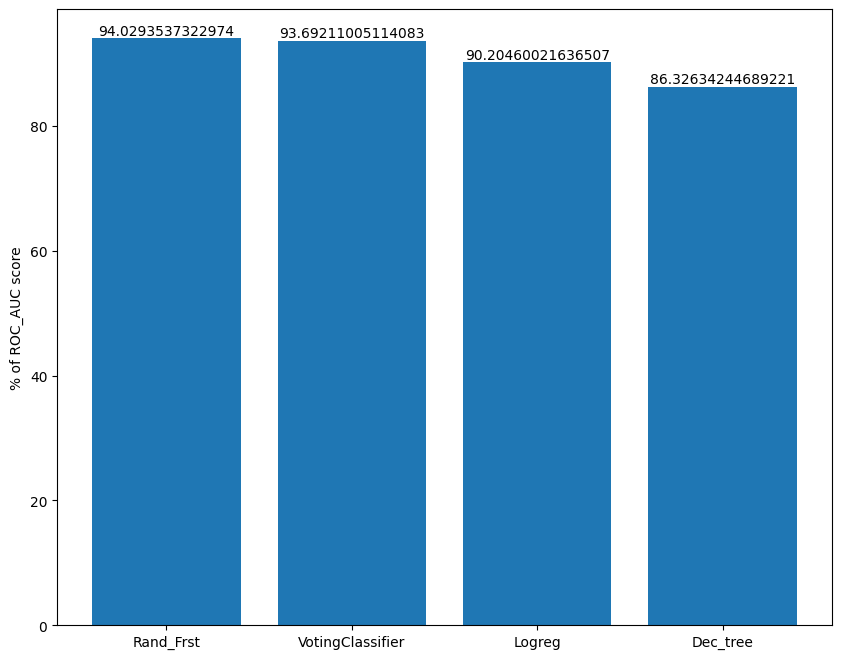

In [69]:

# create a sample dataframe with roc_auc values
data = {'Classifiers': ['Logreg','Dec_tree','Rand_Frst','VotingClassifier'],
        'Val_Scores': score_lst}
df = pd.DataFrame(data)

# convert the roc_auc values to percentages
df['Val_Scores'] = df['Val_Scores']*100

df_sorted = df.sort_values(by='Val_Scores', ascending=False)

plt.bar(df_sorted['Classifiers'], df_sorted['Val_Scores'])
# set the x-axis labels
plt.xticks(df['Classifiers'])

# add text labels to the bars
for i, v in enumerate(df_sorted['Val_Scores']):
    plt.text(i, v, str(v), ha='center', va='bottom')  

plt.ylabel('% of ROC_AUC score')

#### Comments:
From the ensemble, the model roc_auc metric is found to be higher as compared to the individual decision trees, from ensemble, the random forest and logistic regression model are considered to be the better model.

## Summary from Insights:
1. Presence of heart diseases in patients are assesed by fitting into different models of regression and classification.
2. As the target variable is categorical, then models of logistic regression, random forest and decision trees are fitted, however, the models suffered from the issues of severe overfitting, multicollinearity, skewness and outliers in the data.
3. The problems of overfitting issues are high when model is fitted in decision trees, showing huge difference in the training and testing data performance metrics.
4. So, with hyper parameters tuning using grid search CV improved the models performance metrics like accuracy, recall, precision. 
5. With the best model parameters, the training data is cross validated with 6 folds to find the best performance.
6. Overall, from the roc curves of validation metrics, the Random Forest model is slightly higher in comparison to the decision trees and logistic regression.
7. Overall, Random Forest is considered to be the better model for predicting in stream lit web deployment

## Conclusion:


  In conclusion, The heart failure prediction model developed in this project has demonstrated the potential to predict the likelihood of heart failure in patients based on their medical history other factors.
This model can be a useful tool for healthcare professionals to identify patients who are at high risk of heart failure and provide them with appropriate preventive measures and treatments.
The accuracy and reliability of the heart failure prediction model depends on the quality and completeness of the data used to train it.
Further research is necessary to validate its performance on larger and more diverse datasets.

## References:
